In [3]:
from tqdm import tqdm
import skillsnetwork
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

sns.set_context('notebook')
sns.set_style('white')

In [4]:
await skillsnetwork.download_dataset('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX056YEN/churn.csv')
df_churn_pd = pd.read_csv('churn.csv')

df_churn_pd.head()

Saved as 'churn.csv'


,ID,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
0,1703,Medium,NaN,M,2,28766.9,N,47,6110.61,58,1527.6525,152.76525,8.70,2,13,0.0000,152.76525
1,1704,Low,NaN,M,2,91272.2,Y,25,26992.70,13,13496.3500,1349.63500,3.25,4,10,1349.6350,0.00000
2,1705,Low,NaN,S,0,73228.3,N,42,22472.25,28,11236.1250,1123.61250,7.00,4,5,1123.6125,0.00000
3,1706,High,M,M,1,64792.3,N,52,13051.31,36,6525.6550,652.56550,9.00,3,6,0.0000,652.56550
4,1707,High,F,S,0,93322.1,Y,40,29922.99,8,14961.4950,1496.14950,2.00,4,9,0.0000,1496.14950


In [5]:
print("The dataset contains columns of the following data types : \n" + str(df_churn_pd.dtypes))


The dataset contains columns of the following data types : 
ID                             int64
CHURNRISK                     object
GENDER                        object
STATUS                        object
CHILDREN                       int64
ESTINCOME                    float64
HOMEOWNER                     object
AGE                            int64
TOTALDOLLARVALUETRADED       float64
TOTALUNITSTRADED               int64
LARGESTSINGLETRANSACTION     float64
SMALLESTSINGLETRANSACTION    float64
PERCENTCHANGECALCULATION     float64
DAYSSINCELASTLOGIN             int64
DAYSSINCELASTTRADE             int64
NETREALIZEDGAINS_YTD         float64
NETREALIZEDLOSSES_YTD        float64
dtype: object


In [7]:
print("The dataset contains following number of records for each of the columns: \n" +str(df_churn_pd.count()))

The dataset contains following number of records for each of the columns: 
ID                           2066
CHURNRISK                    2066
GENDER                       2063
STATUS                       2066
CHILDREN                     2066
ESTINCOME                    2066
HOMEOWNER                    2066
AGE                          2066
TOTALDOLLARVALUETRADED       2066
TOTALUNITSTRADED             2066
LARGESTSINGLETRANSACTION     2066
SMALLESTSINGLETRANSACTION    2066
PERCENTCHANGECALCULATION     2066
DAYSSINCELASTLOGIN           2066
DAYSSINCELASTTRADE           2066
NETREALIZEDGAINS_YTD         2066
NETREALIZEDLOSSES_YTD        2066
dtype: int64


Each category within the churnrisk column has the following count : 
CHURNRISK
High      983
Low       699
Medium    384
dtype: int64


Text(0, 0.5, 'Frequency')

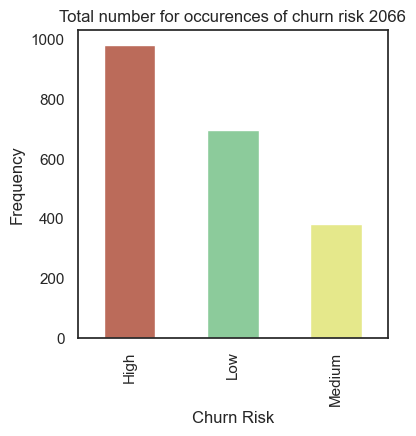

In [8]:
print("Each category within the churnrisk column has the following count : ")
print(df_churn_pd.groupby(['CHURNRISK']).size())
#bar chart to show split of data
index = ['High', 'Medium', 'Low']
churn_plot = df_churn_pd['CHURNRISK'].value_counts(sort=True, ascending=False).plot(kind='bar',
            figsize=(4,4), title="Total number for occurences of churn risk "
            + str(df_churn_pd['CHURNRISK'].count()), color=['#BB6B5A', '#8CCB9B', '#E5E88B'])
churn_plot.set_xlabel("Churn Risk")
churn_plot.set_ylabel("Frequency")

In [9]:
df_churn_pd = df_churn_pd.drop(['ID'], axis=1)
df_churn_pd.head()

,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
0,Medium,NaN,M,2,28766.9,N,47,6110.61,58,1527.6525,152.76525,8.70,2,13,0.0000,152.76525
1,Low,NaN,M,2,91272.2,Y,25,26992.70,13,13496.3500,1349.63500,3.25,4,10,1349.6350,0.00000
2,Low,NaN,S,0,73228.3,N,42,22472.25,28,11236.1250,1123.61250,7.00,4,5,1123.6125,0.00000
3,High,M,M,1,64792.3,N,52,13051.31,36,6525.6550,652.56550,9.00,3,6,0.0000,652.56550
4,High,F,S,0,93322.1,Y,40,29922.99,8,14961.4950,1496.14950,2.00,4,9,0.0000,1496.14950


In [10]:
categoricalColumns = ['GENDER', 'STATUS', 'HOMEOWNER']

print("Categorical columns : ")
print(categoricalColumns)

impute_categorical = SimpleImputer(strategy="most_frequent")

onehot_categorical = OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[('impute', impute_categorical), ('onehot', onehot_categorical)])

Categorical columns : 
['GENDER', 'STATUS', 'HOMEOWNER']


In [13]:
numericalColumns = df_churn_pd.select_dtypes(include=[float,int]).columns

print("Numerical columns : " )
print(numericalColumns)

scaler_numerical = StandardScaler()

numerical_transformer = Pipeline(steps=[('scale', scaler_numerical)])

Numerical columns : 
Index(['CHILDREN', 'ESTINCOME', 'AGE', 'TOTALDOLLARVALUETRADED',
       'TOTALUNITSTRADED', 'LARGESTSINGLETRANSACTION',
       'SMALLESTSINGLETRANSACTION', 'PERCENTCHANGECALCULATION',
       'DAYSSINCELASTLOGIN', 'DAYSSINCELASTTRADE', 'NETREALIZEDGAINS_YTD',
       'NETREALIZEDLOSSES_YTD'],
      dtype='object')


In [14]:
preprocessorForCategoricalColumns = ColumnTransformer(transformers=[('cat', categorical_transformer,
                                                                    categoricalColumns) ],
                                            remainder="passthrough" )
preprocessorForAllColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns),
                                                            ('num', numerical_transformer, numericalColumns) ],
                                                remainder="passthrough" )

#. The transformation happens in the pipeline. Temporarily done here to show what intermediate value looks like
df_churn_pd_temp = preprocessorForCategoricalColumns.fit_transform(df_churn_pd)

print("Data after transforming :")

print(df_churn_pd_temp)

df_churn_pd_temp_2 = preprocessorForAllColumns.fit_transform(df_churn_pd)
print("Data after transforming :")
print(df_churn_pd_temp_2)

Data after transforming :
[[1.0 0.0 0.0 ... 13 0.0 152.76525]
 [1.0 0.0 0.0 ... 10 1349.635 0.0]
 [1.0 0.0 0.0 ... 5 1123.6125 0.0]
 ...
 [1.0 0.0 0.0 ... 11 0.0 82.50825]
 [1.0 0.0 0.0 ... 5 930.093 0.0]
 [0.0 1.0 0.0 ... 8 1041.604 0.0]]
Data after transforming :
[[1.0 0.0 0.0 ... -0.6792731303453047 -0.5106065181930338 'Medium']
 [1.0 0.0 0.0 ... 1.8354629319820521 -0.7959345330293706 'Low']
 [1.0 0.0 0.0 ... 1.4143217110983428 -0.7959345330293706 'Low']
 ...
 [1.0 0.0 0.0 ... -0.6792731303453047 -0.6418293606808149 'Medium']
 [1.0 0.0 0.0 ... 1.053742394902809 -0.7959345330293706 'Low']
 [0.0 1.0 0.0 ... 1.261517632686496 -0.7959345330293706 'Low']]


In [15]:

features = []
features = df_churn_pd.drop(['CHURNRISK'], axis=1)

label_churn = pd.DataFrame(df_churn_pd, columns = ['CHURNRISK'])
label_encoder = LabelEncoder()
label = df_churn_pd['CHURNRISK']

label = label_encoder.fit_transform(label)
print("Encoded value of Churnrisk after applying label encoder : " + str(label))


Encoded value of Churnrisk after applying label encoder : [2 1 1 ... 2 1 1]


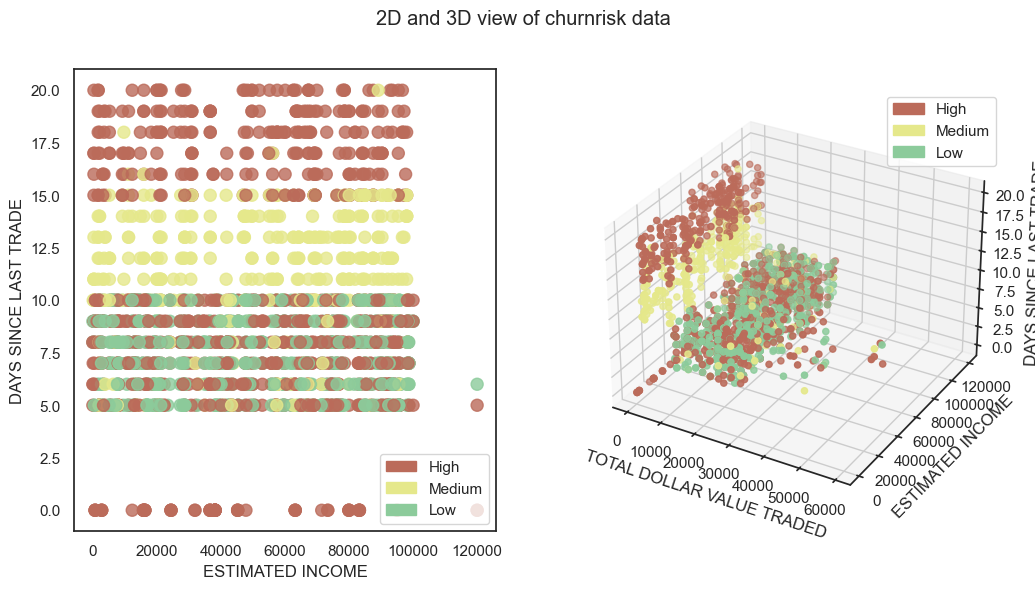

In [16]:
area = 75
x = df_churn_pd['ESTINCOME']
y = df_churn_pd['DAYSSINCELASTTRADE']
z = df_churn_pd['TOTALDOLLARVALUETRADED']

pop_a = mpatches.Patch(color='#BB6B5A', label='High')
pop_b = mpatches.Patch(color='#E5E88B', label='Medium')
pop_c = mpatches.Patch(color='#8CCB9B', label='Low')
def colormap(risk_list):
    cols=[]
    for l in risk_list:
        if l==0:
            cols.append('#BB6B5A')
        elif l==2:
            cols.append('#E5E88B')
        elif l==1:
            cols.append('#8CCB9B')
    return cols

fig = plt.figure(figsize=(12,6))
fig.suptitle('2D and 3D view of churnrisk data')

# First subplot
ax = fig.add_subplot(1, 2,1)

ax.scatter(x, y, alpha=0.8, c=colormap(label), s= area)
ax.set_ylabel('DAYS SINCE LAST TRADE')
ax.set_xlabel('ESTIMATED INCOME')

plt.legend(handles=[pop_a,pop_b,pop_c])

# Second subplot
ax = fig.add_subplot(1,2,2, projection='3d')

ax.scatter(z, x, y, c=colormap(label), marker='o')

ax.set_xlabel('TOTAL DOLLAR VALUE TRADED')
ax.set_ylabel('ESTIMATED INCOME')
ax.set_zlabel('DAYS SINCE LAST TRADE')

plt.legend(handles=[pop_a,pop_b,pop_c])

plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, label, random_state=0)
print("Dimensions of datasets that will be used for training : Input features" + str(X_train.shape) + " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features" + str(X_test.shape) + " Output label" + str(y_test.shape))

Dimensions of datasets that will be used for training : Input features(1549, 15) Output label(1549,)
Dimensions of datasets that will be used for testing : Input features(517, 15) Output label(517,)


In [18]:
model_name = "Random Forest Classifier"

randomForestClassifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

In [19]:
rfc_model = Pipeline(steps=[('preprocessorAll', preprocessorForAllColumns), ('classifier', randomForestClassifier)])

In [20]:
rfc_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessorAll',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['GENDER', 'STATUS',
                                                   'HOMEOWNER']),
                                                 ('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  Index(['CHILDREN', 'ESTINCOME', 'AGE', 'TOTALDOLLARVALUETRADED',
       'TOTALUNITSTRADED', 'LARGESTSINGLETRANSACTION',
       'SMALLESTSINGLETRANSACTION', 'PERCENTCHANGECALCULATION',
       'DAYSSINCELASTLOGIN', 'DAYSSINCELASTTRADE', 'NETREALIZEDGAINS_YTD',
       'NETREALIZEDLOSSES_YTD'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=2, random_state=0))])

In [21]:
y_pred_rfc = rfc_model.predict(X_test)

In [22]:
def colormap(risk_list):
    cols=[]
    for l in risk_list:
        if l==0:
            cols.append('#BB6B5A')
        elif l==2:
            cols.append('#E5E88B')
        elif l==1:
            cols.append('#8CCB9B')
    return cols

def two_d_compare(y_test,y_pred,model_name):
    #y_pred = label_encoder.fit_transform(y_pred)
    #y_test = label_encoder.fit_transform(y_test)
    area = (12 * np.random.rand(40))**2 
    plt.subplots(ncols=2, figsize=(10,4))
    plt.suptitle('Actual vs Predicted data : ' +model_name + '. Accuracy : %.2f' % accuracy_score(y_test, y_pred))

    plt.subplot(121)
    plt.scatter(X_test['ESTINCOME'], X_test['DAYSSINCELASTTRADE'], alpha=0.8, c=colormap(y_test))
    plt.title('Actual')
    plt.legend(handles=[pop_a,pop_b,pop_c])

    plt.subplot(122)
    plt.scatter(X_test['ESTINCOME'], X_test['DAYSSINCELASTTRADE'],alpha=0.8, c=colormap(y_pred))
    plt.title('Predicted')
    plt.legend(handles=[pop_a,pop_b,pop_c])

    plt.show()
    
x = X_test['TOTALDOLLARVALUETRADED']
y = X_test['ESTINCOME']
z = X_test['DAYSSINCELASTTRADE']

pop_a = mpatches.Patch(color='#BB6B5A', label='High')
pop_b = mpatches.Patch(color='#E5E88B', label='Medium')
pop_c = mpatches.Patch(color='#8CCB9B', label='Low')

def three_d_compare(y_test,y_pred,model_name):
    fig = plt.figure(figsize=(12,10))
    fig.suptitle('Actual vs Predicted (3D) data : ' +model_name + '. Accuracy : %.2f' % accuracy_score(y_test, y_pred))
    
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=colormap(y_test), marker='o')
    ax.set_xlabel('TOTAL DOLLAR VALUE TRADED')
    ax.set_ylabel('ESTIMATED INCOME')
    ax.set_zlabel('DAYS SINCE LAST TRADE')
    plt.legend(handles=[pop_a,pop_b,pop_c])
    plt.title('Actual')

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(x, y, z, c=colormap(y_pred), marker='o')
    ax.set_xlabel('TOTAL DOLLAR VALUE TRADED')
    ax.set_ylabel('ESTIMATED INCOME')
    ax.set_zlabel('DAYS SINCE LAST TRADE')
    plt.legend(handles=[pop_a,pop_b,pop_c])
    plt.title('Predicted')

    plt.show()
    

def model_metrics(y_test,y_pred):
    print("Decoded values of Churnrisk after applying inverse of label encoder : " + str(np.unique(y_pred)))

    skplt.metrics.plot_confusion_matrix(y_test,y_pred,text_fontsize="small",cmap='Greens',figsize=(6,4))
    plt.show()
    
    print("The classification report for the model : \n\n"+ classification_report(y_test, y_pred))

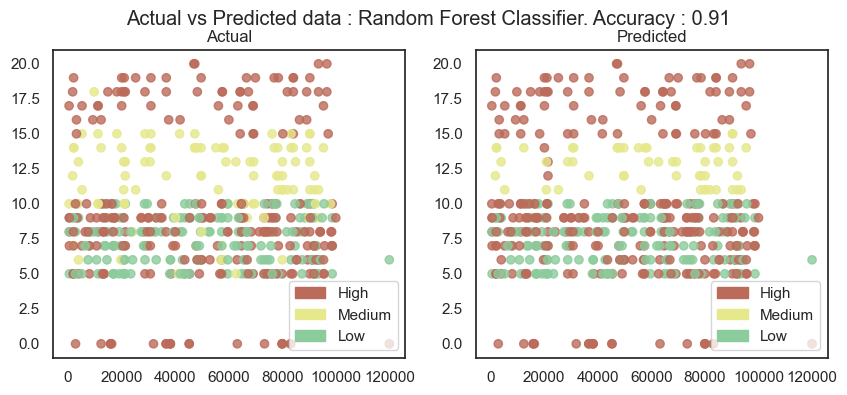

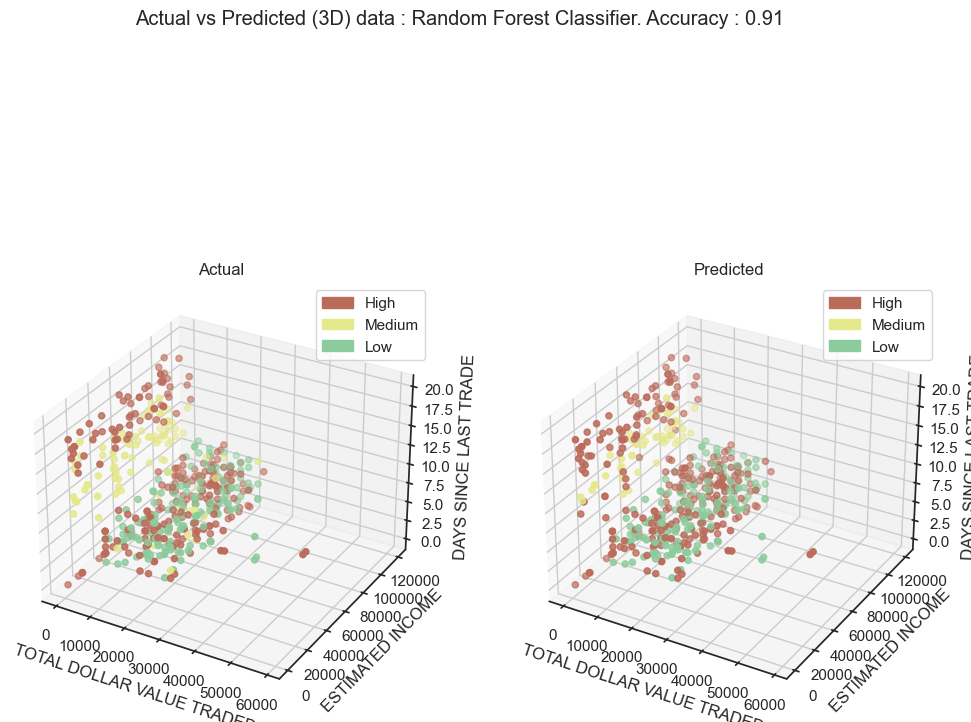

In [23]:
two_d_compare(y_test, y_pred_rfc, model_name)
              
three_d_compare(y_test,y_pred_rfc,model_name)

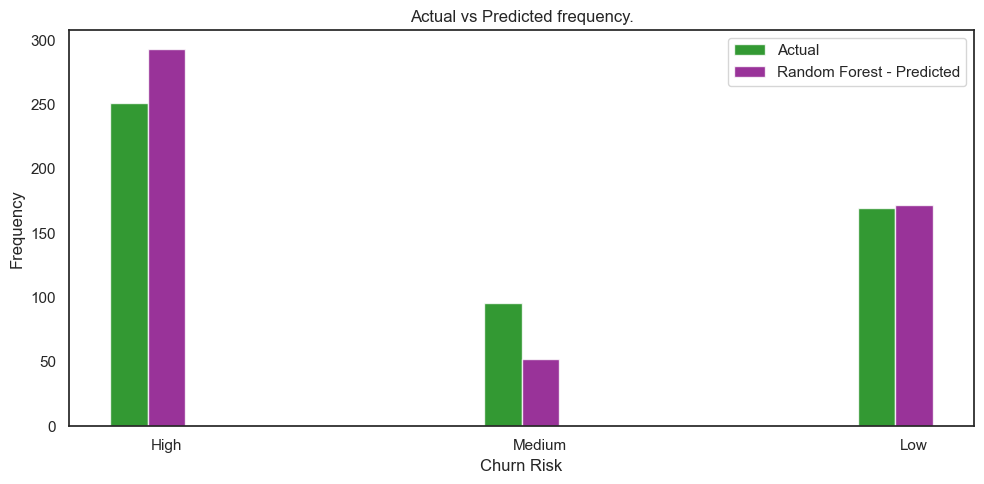

In [27]:
uniqueValues, occurCount = np.unique(y_test, return_counts=True)
frequency_actual = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_rfc, return_counts=True)
frequency_predicted_rfc = (occurCount[0],occurCount[2],occurCount[1])

n_groups = 3
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, frequency_actual, bar_width,
alpha=opacity,
color='g',
label='Actual')

rects6 = plt.bar(index + bar_width, frequency_predicted_rfc, bar_width,
alpha=opacity,
color='purple',
label='Random Forest - Predicted')

plt.xlabel('Churn Risk')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted frequency.')
plt.xticks(index + bar_width, ('High', 'Medium', 'Low'))
plt.legend()

plt.tight_layout()
plt.show()